In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import japanize_matplotlib

In [14]:
# 3000x3000の座標平面を作成
x = np.linspace(0, 3000, 3000)
y = np.linspace(0, 3000, 3000)
X, Y = np.meshgrid(x, y)

# 電波発信端末の座標とGMMのパラメータを設定
transmitter_1 = [500, 500]  # 端末1の平均 (中心座標)
transmitter_2 = [2500, 2500]  # 端末2の平均 (中心座標)

covariance_matrix_1 = [[1, 0], [0, 1]]  # 端末1の共分散行列
covariance_matrix_2 = [[0, 1], [0, 1]]  # 端末2の共分散行列
weights = [0.5, 0.5]  # GMMの重み

# ガウス混合モデルを初期化
gmm = GaussianMixture(n_components=2, covariance_type="full", weights_init=weights)

# ガウス混合モデルを学習
gmm.means_init = np.array([transmitter_1, transmitter_2])
gmm.covariances_init = np.array([covariance_matrix_1, covariance_matrix_2])
gmm.fit(np.column_stack((X.ravel(), Y.ravel())))

# 各座標点での電波強度を計算
Z = -gmm.score_samples(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

# Zの最大値を取得
Z_max = np.max(Z)

# 実際のRSSI値にスケーリング (例: -30dBm から -90dBm の範囲)
RSSI_max = -30  # dBm
RSSI_min = -90  # dBm

# 正規化された Z を実際のRSSI値にスケーリング
# 中心に近づくほどRSSIが大きく（0に近く）、外側に行くほど小さく（負の値が大きく）なるようにする
RSSI = RSSI_max + (Z / Z_max) * (RSSI_min - RSSI_max)

print(RSSI)

[[-89.99999717 -89.98845122 -89.97691958 ... -89.58944263 -89.60013056
  -89.6108328 ]
 [-89.99331971 -89.98177405 -89.97024269 ... -89.58302415 -89.59371236
  -89.60441488]
 [-89.98664663 -89.97510124 -89.96357017 ... -89.57661004 -89.58729853
  -89.59800133]
 ...
 [-89.59799227 -89.58728911 -89.57660027 ... -89.96357383 -89.97510449
  -89.98664947]
 [-89.60440582 -89.59370294 -89.58301438 ... -89.97024636 -89.98177729
  -89.99332255]
 [-89.61082374 -89.60012114 -89.58943286 ... -89.97692324 -89.98845446
  -90.        ]]


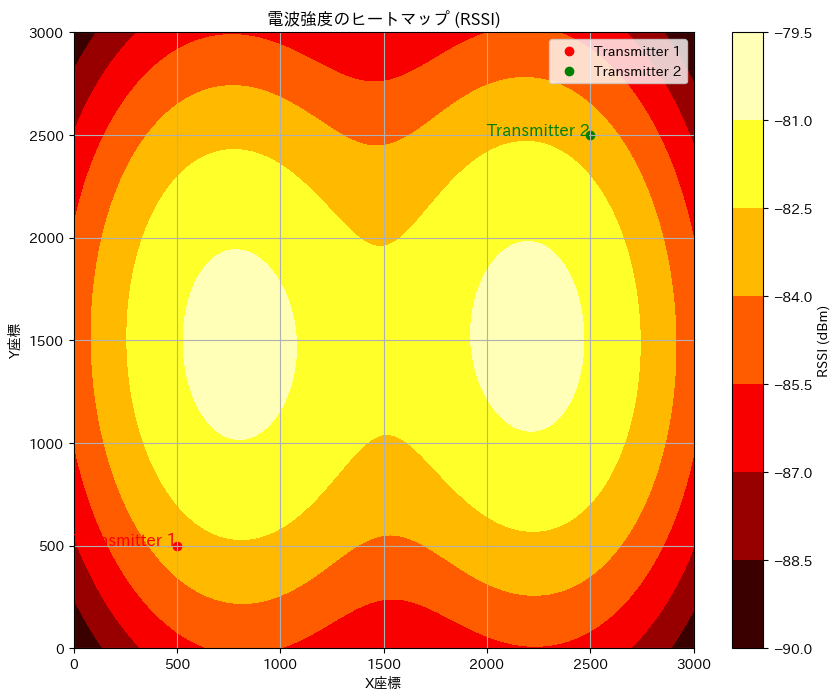

指定されたRSSI値(-85dBm)に近い座標数: 1217332
絞り込んだ座標のサンプル:
[(2933, 2087), (712, 2829), (27, 1972), (1749, 351), (911, 6), (1933, 2912), (123, 2434), (71, 2244), (2368, 2840), (1396, 2707)]


In [15]:
# 指定されたRSSI値の座標を絞り込む
target_RSSI = -85  # 絞り込みたいRSSI値 (例: -60dBm)
tolerance = 0.5  # 許容誤差 (例: ±0.5dBm)

# 絞り込み条件に合致する座標を取得
indices = np.where(
    (RSSI >= target_RSSI - tolerance) & (RSSI <= target_RSSI + tolerance)
)
filtered_coordinates = list(zip(X[indices], Y[indices]))

# 座標を丸める
rounded_coordinates = [(round(x), round(y)) for x, y in filtered_coordinates]

# 重複を削除
unique_coordinates = list(set(rounded_coordinates))


# プロット
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, RSSI, cmap="hot")
plt.colorbar(label="RSSI (dBm)")

plt.scatter(
    transmitter_1[0], transmitter_1[1], color="red", marker="o", label="Transmitter 1"
)
plt.scatter(
    transmitter_2[0], transmitter_2[1], color="green", marker="o", label="Transmitter 2"
)
plt.text(
    transmitter_1[0],
    transmitter_1[1],
    "Transmitter 1",
    color="red",
    fontsize=12,
    ha="right",
)
plt.text(
    transmitter_2[0],
    transmitter_2[1],
    "Transmitter 2",
    color="green",
    fontsize=12,
    ha="right",
)
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title("電波強度のヒートマップ (RSSI)")
plt.legend()
plt.grid(True)
plt.show()

# 絞り込んだ座標の表示
print(f"指定されたRSSI値({target_RSSI}dBm)に近い座標数: {len(unique_coordinates)}")
if len(unique_coordinates) > 0:
    print("絞り込んだ座標のサンプル:")
    print(unique_coordinates[:10])  # 最初の10個を表示
else:
    print("指定されたRSSI値に近い座標が見つかりませんでした。")